# <h1> <center> Pothole Detection </center> </h1>

The objective of this project is to develop a robust pothole detection system leveraging Artificial Neural Networks (ANN) and Convolutional Neural Networks (CNN) and transfer learning.

We have taken this dataset from kaggle.
The link for the same is: https://www.kaggle.com/code/tourist55/pothole-detection-final-project/input

The dataset contains images, which has be classified into two groups.
1. Images with potholes
2. Image without potholes

The project is divide into the following sections

1. Data Acquisition and Preprocessing
2. ANN-based Feature Learning
3. CNN-based Image Feature Extraction
4. InceptionV3
5. Model Evaluation and Optimization



### Importing Libraries:
The code imports Python libraries and modules for tasks related to machine learning, deep learning, and data visualization. The libraries include NumPy, Pandas, Matplotlib, IPython, Scikit-Learn, TensorFlow, and Seaborn. The code sets up an environment for working with convolutional neural networks (CNNs) and includes functionalities for image processing, model building, and performance evaluation.

In [ ]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from time import perf_counter
import seaborn as sns

### Importing the dataset:

Here normal_images is a variable containing the directory path for normal images, and normal_images_list is a list of filenames in that directory. The list comprehension then creates a new list with complete file paths for each normal image.

In [ ]:
pothole_images = 'data/potholes/'
pothole_images_list = os.listdir('data/potholes/')
pothole_images_list = [pothole_images + f for f in pothole_images_list]

normal_images = 'data/normal/'
normal_images_list = os.listdir(normal_images)
normal_images_list = [normal_images + f for f in normal_images_list]

### Creating a Data Farme:

#### Creating a DataFrame with columns 'Path', 'Label', and 'Label_String' based on pothole and normal image paths.
• Assigning labels (0 for 'normal' and 1 for 'pothole') based on the presence of 'normal' in the path.

• Converting numerical labels to string labels ('normal' and 'pothole').

• Shuffling the rows of the DataFrame randomly using the sample method. The frac=1.0 parameter means that the entire DataFrame is selected. The reset_index(drop=True) resets the index of the DataFrame after shuffling.



In [ ]:
df = pd.DataFrame({'Path': pothole_images_list + normal_images_list})
df['Label'] = df['Path'].apply(lambda x: 0 if 'normal' in x else 1)
df['Label_String'] = df['Label'].apply(lambda x: 'normal' if x == 0 else 'pothole')

# Shuffle
df = df.sample(frac = 1.0).reset_index(drop = True)

# Display the first lines
pd.options.display.max_colwidth = 200
df.head()

,Path,Label,Label_String
0,data/normal/109.jpg,0,normal
1,data/potholes/309.jpg,1,pothole
2,data/potholes/202.jpg,1,pothole
3,data/normal/10.jpg,0,normal
4,data/potholes/306.jpg,1,pothole


In [ ]:
df[df['Label'] == 0]

,Path,Label,Label_String
0,data/normal/109.jpg,0,normal
3,data/normal/10.jpg,0,normal
5,data/normal/227.jpg,0,normal
6,data/normal/35.jpg,0,normal
7,data/normal/140.jpg,0,normal
...,...,...,...
671,data/normal/161.jpg,0,normal
674,data/normal/71.jpg,0,normal
676,data/normal/292.jpg,0,normal
677,data/normal/278.jpg,0,normal


### EDA (Exploratory Data Analytics):
 Using Matplotlib to create a bar plot showing the distribution of labels ('normal' and 'pothole') in the DataFrame.
 The plot has provides the data distribution between normal and potholes.


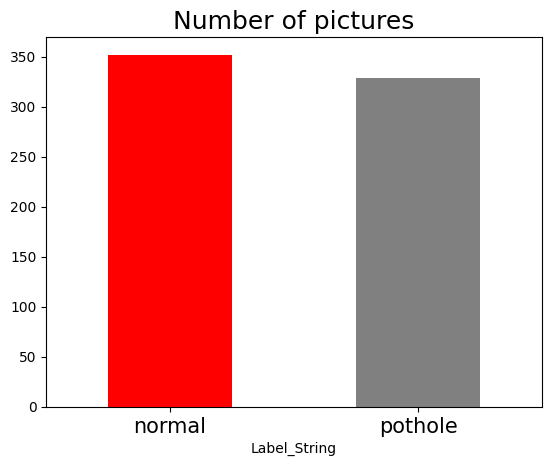

In [ ]:
df['Label_String'].value_counts().plot.bar(color = ['red','gray'])
plt.title('Number of pictures', fontsize = 18)
plt.xticks(rotation = 0, fontsize = 15)
plt.show()

### Lets see some images from the dataset


A loop iterates through each subplot in the grid (axes.flat). Inside the loop.

1. It loads an image using image.load_img from the file path in the 'Path' column of the DataFrame.

2. Displays the image on the current subplot using ax.imshow.

3. Retrieves the corresponding label from the 'Label_String' column and sets it as the title of the subplot using ax.set_title.


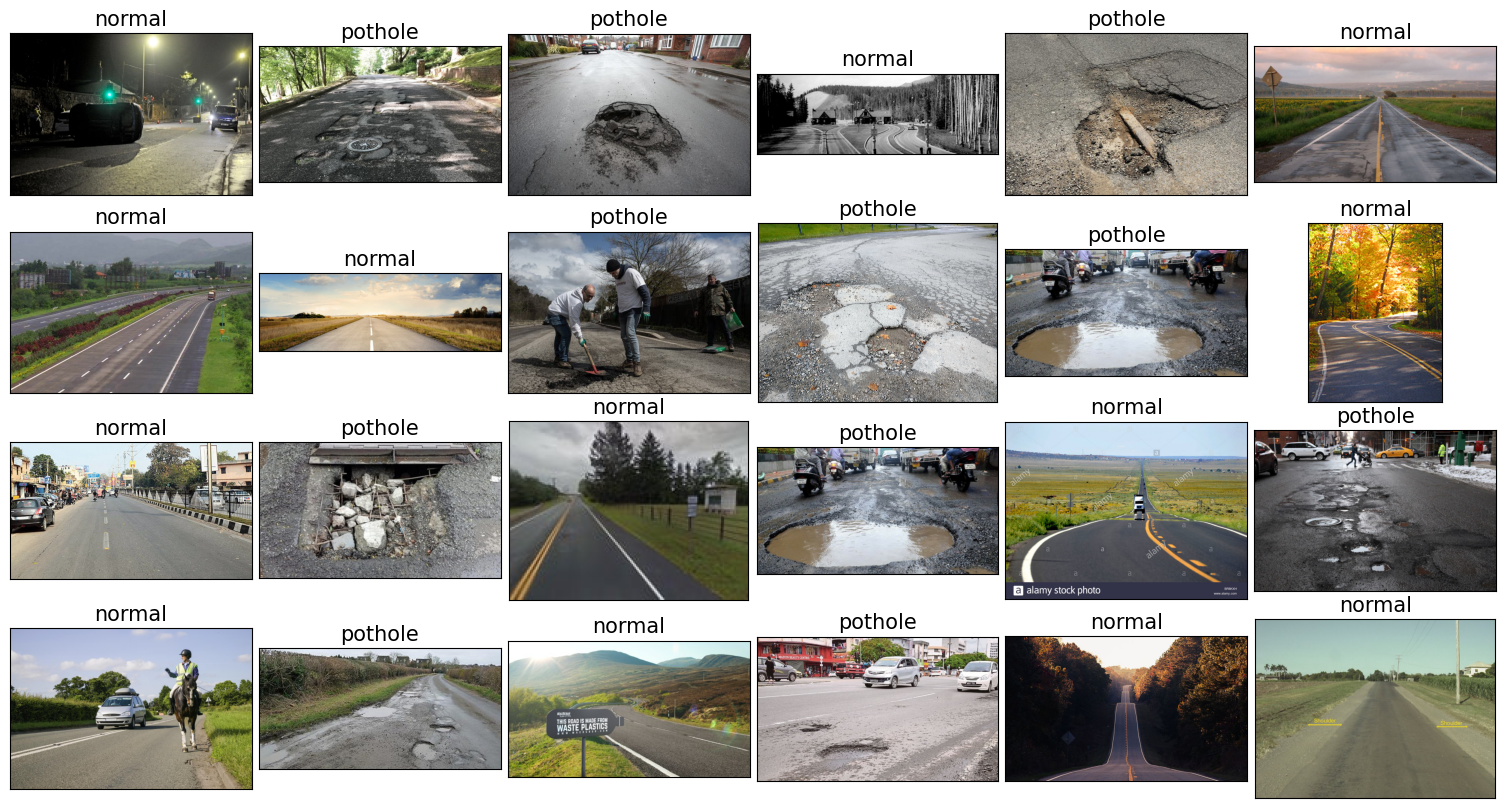

In [ ]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = image.load_img(df['Path'].iloc[i])
    ax.imshow(img, cmap = 'gray')
    title = df['Label_String'].iloc[i]
    ax.set_title(title, fontsize = 15)
plt.tight_layout(pad=0.5)
plt.show()

### Preprocessing the data
#### Here we creating a preprocessing function
We will pass the image file path into the function and then the function will perform:

• Read the image (converting into vectors)

• Resizing the image

In [ ]:
def preprocessing_image(filepath):
  img = cv2.imread(filepath) #read
  img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR) #convert
  img = cv2.resize(img,(196,196))  # resize
  img = img / 255 #scale
  return img

### This function loops through each row of the input DataFrame
Loads and preprocesses the corresponding image using preprocessing_image
appends the preprocessed image to the X list and its corresponding label to the y list.

In [ ]:
def create_format_dataset(dataframe):
  X = []
  y = []
  for p,l,n in dataframe.values:
    i = cv2.imread(p)
    if i is not None:
        X.append(preprocessing_image(p))
        y.append(l)
    else:
        print(f"Error loading image: {p}")

  return np.array(X),np.array(y)

In [ ]:
X,y = create_format_dataset(df)

Error loading image: data/normal/226.jpg


In [ ]:
(X).shape, (y).shape

((680, 196, 196, 3), (680,))

### Split the Dataset into training and testing set



train_test_split: This function splits arrays or matrices into random train and test subsets. Here, it's used to split the features (X) and labels (y) into training and testing sets.

X_train, X_test, y_train, y_test: These variables store the resulting training and testing sets for features and labels.

test_size=0.2: Specifies that 20% of the data will be used for testing, and the remaining 80% will be used for training.


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,stratify = y)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((544, 196, 196, 3), (136, 196, 196, 3), (544,), (136,))

In [ ]:
y_test

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1])

## ANN Model

• Flatten(input_shape=(196, 196, 3)): Flattens the input, which is expected to be an image with shape (196, 196, 3) (width, height, channels).

• Dense(100, activation='relu'), Dense(150, activation='relu'), ...: Fully connected (dense) layers with varying numbers of units (neurons) and ReLU activation functions. This architecture includes multiple hidden layers.

• Dropout(0.15): A dropout layer that randomly sets 15% of the input units to 0 at each update during training. This is a regularization technique to prevent overfitting.

• Dense(1, activation='sigmoid'): Output layer with a single unit and sigmoid activation function, suitable for binary classification tasks. The sigmoid activation function outputs values between 0 and 1, representing the probability of the positive class.

In [ ]:
from tensorflow.keras import datasets, models
from tensorflow.keras.layers import Flatten, Dense, Dropout

ann = models.Sequential([
    Flatten(input_shape=(196, 196, 3)),
    Dense(100, activation='relu'),
    Dense(150, activation='relu'),
    Dense(150, activation='relu'),
    Dense(150, activation='relu'),
    Dense(100, activation='relu'),
    Dropout(0.15),
    Dense(1, activation='sigmoid')  ])

In [ ]:
ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 115248)            0         
                                                                 
 dense (Dense)               (None, 100)               11524900  
                                                                 
 dense_1 (Dense)             (None, 150)               15150     
                                                                 
 dense_2 (Dense)             (None, 150)               22650     
                                                                 
 dense_3 (Dense)             (None, 150)               22650     
                                                                 
 dense_4 (Dense)             (None, 100)               15100     
                                                                 
 dropout (Dropout)           (None, 100)               0

In [ ]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import legacy

ann.compile(optimizer=legacy.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)

history = ann.fit(X_train, y_train, epochs=30, batch_size=32,
                  validation_data=(X_test, y_test), callbacks=[es])


Epoch 1/30


c:\Users\Omkar Bhalerao\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\util\dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(32, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)




17/17 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.5165

c:\Users\Omkar Bhalerao\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\util\dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


17/17 [==============================] - 5s 143ms/step - loss: 0.0000e+00 - accuracy: 0.5165 - val_loss: 0.0000e+00 - val_accuracy: 0.5147
Epoch 2/30
17/17 [==============================] - 1s 84ms/step - loss: 0.0000e+00 - accuracy: 0.5165 - val_loss: 0.0000e+00 - val_accuracy: 0.5147
Epoch 3/30
17/17 [==============================] - 1s 88ms/step - loss: 0.0000e+00 - accuracy: 0.5165 - val_loss: 0.0000e+00 - val_accuracy: 0.5147
Epoch 4/30
17/17 [==============================] - 1s 83ms/step - loss: 0.0000e+00 - accuracy: 0.5165 - val_loss: 0.0000e+00 - val_accuracy: 0.5147
Epoch 5/30
17/17 [==============================] - 1s 79ms/step - loss: 0.0000e+00 - accuracy: 0.5165 - val_loss: 0.0000e+00 - val_accuracy: 0.5147


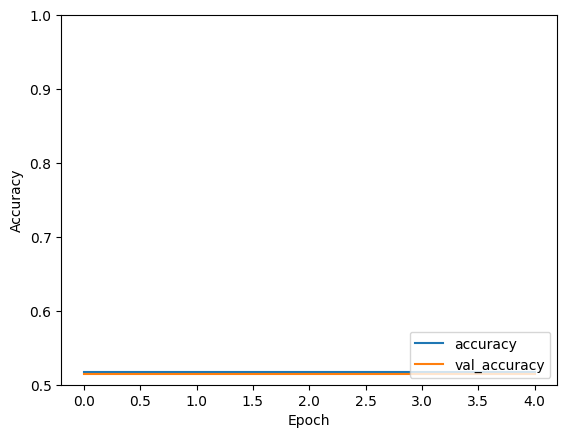

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
ann_test_loss, ann_test_acc = ann.evaluate(X_test, y_test, verbose=2)
print('Best accuracy: ', ann_test_acc)

5/5 - 0s - loss: 0.0000e+00 - accuracy: 0.5147 - 108ms/epoch - 22ms/step
Best accuracy:  0.5147058963775635


## CNN model

#### Convolutional Neural Network (CNN) Overview

It's a simple CNN using Keras for image classification. The model consists of convolutional layers with varying filter sizes and max-pooling layers for spatial reduction. It utilizes the ReLU activation function for feature extraction. The final layers include a flattening operation followed by fully connected layers with 128 neurons and a single output neuron with a sigmoid activation for binary classification.



In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

cnn = Sequential()

cnn.add(Conv2D(128,(2,2),input_shape = (196,196,3),activation='relu'))
cnn.add(Conv2D(64,(2,2),activation='relu'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(32,(2,2),activation='relu'))
cnn.add(MaxPooling2D())

cnn.add(Flatten())
cnn.add(Dense(128))
cnn.add(Dense(1,activation= "sigmoid"))

In [ ]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 195, 195, 128)     1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 194, 194, 64)      32832     
                                                                 
 max_pooling2d (MaxPooling2  (None, 97, 97, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 73728)            

### Convolutional Neural Network (CNN) Training

Here we training the previously defined CNN. It utilizes the Adam optimizer, binary cross-entropy loss function, and accuracy as the metric. The training is performed for 30 epochs with a batch size of 32. Additionally, early stopping is employed with a patience of 10 epochs to prevent overfitting and restore the best weights during training.


In [ ]:
from keras.callbacks import EarlyStopping
callbacks = [EarlyStopping(monitor = 'val_loss',patience = 10,restore_best_weights=True)]
cnn.compile(optimizer='adam',loss = 'binary_crossentropy',metrics=['accuracy'])
cnn.fit(X_train,y_train,validation_data=(X_test,y_test),epochs = 30,batch_size = 32,callbacks = callbacks)


Epoch 1/30
17/17 [==============================] - 61s 3s/step - loss: 1.5193 - accuracy: 0.6324 - val_loss: 0.5579 - val_accuracy: 0.6838
Epoch 2/30
17/17 [==============================] - 46s 3s/step - loss: 0.4838 - accuracy: 0.7629 - val_loss: 0.4175 - val_accuracy: 0.8382
Epoch 3/30
17/17 [==============================] - 47s 3s/step - loss: 0.3924 - accuracy: 0.8125 - val_loss: 0.3534 - val_accuracy: 0.8529
Epoch 4/30
17/17 [==============================] - 46s 3s/step - loss: 0.3096 - accuracy: 0.8732 - val_loss: 0.4723 - val_accuracy: 0.8529
Epoch 5/30
17/17 [==============================] - 48s 3s/step - loss: 0.2311 - accuracy: 0.8989 - val_loss: 0.2401 - val_accuracy: 0.9118
Epoch 6/30
17/17 [==============================] - 50s 3s/step - loss: 0.1246 - accuracy: 0.9688 - val_loss: 0.2391 - val_accuracy: 0.9118
Epoch 7/30
17/17 [==============================] - 47s 3s/step - loss: 0.0654 - accuracy: 0.9853 - val_loss: 0.2119 - val_accuracy: 0.9191
Epoch 8/30
17/17 [=

In [ ]:
y_pred = cnn.predict(X_test)

5/5 [==============================] - 3s 361ms/step


In [ ]:
cnn_test_loss, cnn_test_acc = cnn.evaluate(X_test,  y_test, verbose=2)
print('Best accuracy: ', cnn_test_acc)

5/5 - 2s - loss: 0.2119 - accuracy: 0.9191 - 2s/epoch - 487ms/step
Best accuracy:  0.9191176295280457


Converting the y_pred into integer for plotting the confusion matrix

In [ ]:
y_pred = y_pred.reshape(-1)
y_pred[y_pred<0.5] = 0
y_pred[y_pred>=0.5] = 1
y_pred = y_pred.astype('int')

### Plotting the Confusion matrix

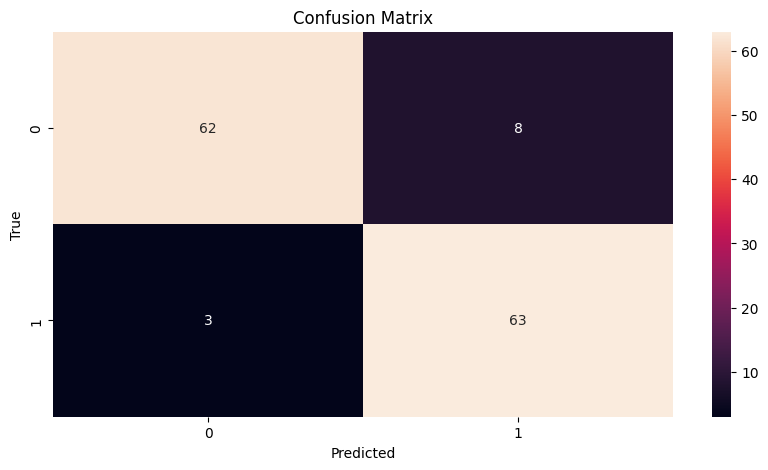

In [ ]:
plt.figure(figsize = (10,5))

sns.heatmap(confusion_matrix(y_test,y_pred),annot = True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92        70
           1       0.89      0.95      0.92        66

    accuracy                           0.92       136
   macro avg       0.92      0.92      0.92       136
weighted avg       0.92      0.92      0.92       136



### InceptionV3
We will now try a different approach: instead of creating a model "from scratch", we will fine-tune a pre-trained model. We will specifically be using InceptionV3, which is a very powerful Convolutional Neural Network.

In order to fine-tune it we will do the following:

Load the base model without the top layer;
Add some layers to classify the input images based on the ouput of the base model;
Train only the added layers by freezing all the others.
Since InceptionV3 expects a specific type of input (pixels scaled between -1 and 1), we will need to preprocess our training and testing data.

The fine-tuning process described was adapted from this guide by Keras.

In [ ]:
from tensorflow.keras import models
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.optimizers import legacy  # Import the legacy optimizer
from tensorflow.keras.callbacks import EarlyStopping

# Load the base model without the top layer: we will add ours for fine-tuning
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(196, 196, 3))

# Create the model: we will add the necessary layers for our task on top of the base model
inception = models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
])

# We will only train the top layers, i.e., the ones we added
# Thus, we need to freeze all the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Use the legacy Adam optimizer with the learning rate
inception.compile(optimizer=legacy.Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Pre-process the data to meet InceptionV3 requirements
x_train_inception = preprocess_input(X_train)
x_test_inception = preprocess_input(X_test)

# Define EarlyStopping callback
es = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Train the model on the new data for a few epochs
history = inception.fit(x_train_inception, y_train, epochs=20,
                        validation_data=(x_test_inception, y_test), callbacks=[es])


87910968/87910968 [==============================] - 7s 0us/step
Epoch 1/20
17/17 [==============================] - 22s 712ms/step - loss: 0.7028 - accuracy: 0.4743 - val_loss: 0.6911 - val_accuracy: 0.4853
Epoch 2/20
17/17 [==============================] - 9s 559ms/step - loss: 0.6952 - accuracy: 0.4945 - val_loss: 0.6861 - val_accuracy: 0.5147
Epoch 3/20
17/17 [==============================] - 9s 558ms/step - loss: 0.6875 - accuracy: 0.5386 - val_loss: 0.6824 - val_accuracy: 0.6029
Epoch 4/20
17/17 [==============================] - 10s 569ms/step - loss: 0.6819 - accuracy: 0.5919 - val_loss: 0.6789 - val_accuracy: 0.6471
Epoch 5/20
17/17 [==============================] - 9s 551ms/step - loss: 0.6777 - accuracy: 0.6379 - val_loss: 0.6752 - val_accuracy: 0.7059
Epoch 6/20
17/17 [==============================] - 15s 923ms/step - loss: 0.6730 - accuracy: 0.6618 - val_loss: 0.6716 - val_accuracy: 0.7353
Epoch 7/20
17/17 [==============================] - 11s 648ms/step - loss: 0.667

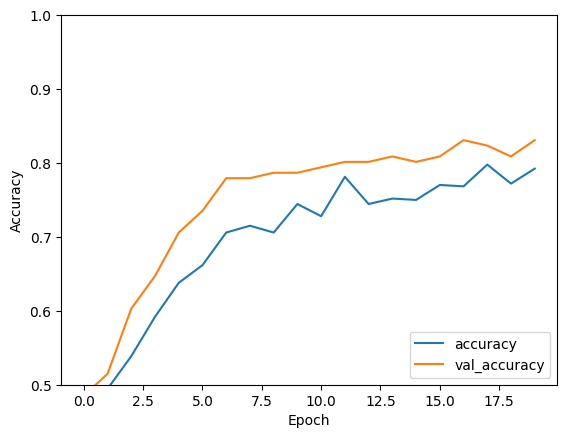

In [ ]:
# plot the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
inception_test_loss, inception_test_acc = inception.evaluate(x_test_inception,  y_test, verbose=2)
print('Best accuracy: ', inception_test_acc)

5/5 - 3s - loss: 0.6254 - accuracy: 0.8309 - 3s/epoch - 518ms/step
Best accuracy:  0.8308823704719543


### Model Accuracy Comparison

We will now be comparing the accuracy of three different models: ANN, CNN, and InceptionV3, on a validation set. The accuracy is calculated as a percentage and printed for each model. From these results, we can see that the CNN model has the highest accuracy on the validation set, followed by InceptionV3, and then ANN. This suggests that the CNN model is performing the best among the three models on this particular validation set.

In [ ]:
print('ANN accuracy: ', ann_test_acc*100)
print('CNN accuracy: ', cnn_test_acc*100)
print('InceptionV3 accuracy: ', inception_test_acc*100)

ANN accuracy:  51.47058963775635
CNN accuracy:  91.91176295280457
InceptionV3 accuracy:  83.08823704719543


### AUC Calculation and ROC Curve Plotting Function

##### This Python code defines a function, plot_auc, which calculates the Area Under the Curve (AUC) and plots the Receiver Operating Characteristic (ROC) curve for a given model. The function takes four parameters: the model, the test data, the test labels, and the name of the model.

First, it uses the model to predict the labels for the test data. Then, it calculates the False Positive Rate (FPR) and True Positive Rate (TPR) using the roc_curve function from sklearn’s metrics module. The AUC is then calculated using the auc function, and the result is printed.

Finally, the ROC curve is plotted using matplotlib’s plot function, with the FPR on the x-axis and the TPR on the y-axis. The model’s name is used as the label for the plot. This function is useful for evaluating the performance of binary classification models.

In [ ]:
from sklearn.metrics import roc_curve, auc

# function to calculate AUC and plot ROC curve for a given model
def plot_auc(model, x_test, y_test, model_name):
    # calculate predictions
    y_pred = model.predict(x_test)


    # calculate and plot False Positve and True Positive rates
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # print AUC
    roc_auc = auc(fpr, tpr)
    print(f'AUC of {model_name}: {roc_auc}')

    # plot ROC curve
    plt.plot(fpr, tpr, label=model_name)

### ROC Curve Plotting
##### We will now be plotting the Receiver Operating Characteristic (ROC) curves for three different models: ANN, CNN, and InceptionV3. 

5/5 [==============================] - 1s 44ms/step
AUC of ANN: 0.40378787878787875
5/5 [==============================] - 4s 384ms/step
AUC of CNN: 0.8792207792207792
5/5 [==============================] - 6s 437ms/step
AUC of InceptionV3: 0.8850649350649351


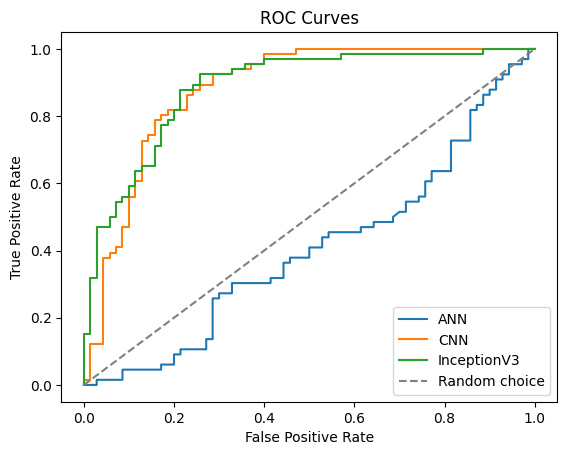

In [ ]:
plot_auc(ann, X_test, y_test, 'ANN')
plot_auc(cnn, X_test, y_test, 'CNN')
plot_auc(inception, x_test_inception, y_test, 'InceptionV3')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random choice')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()